In [ ]:
import numpy as np      
import pandas as pd       
from tqdm import tqdm, tqdm_notebook
import random   
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences  
import re

# 데이터 샘플링
from imblearn.under_sampling import RandomUnderSampler 

# lstm_model 관련
from keras.layers import *      
from keras import backend as K    
from keras import optimizers    
import keras    
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, BatchNormalization, Dropout 
from keras.models import Sequential   
from keras import Input, Model 

# 시각화 라이브러리
import matplotlib.pyplot as plt   
import seaborn as sns

# Word2Vec 모델 관련
from gensim.models import Word2Vec, Phrases   
from gensim.models import KeyedVectors  

# 하이퍼파라미터와 CV(Cross Validation) 관련
from sklearn.model_selection import GridSearchCV, StratifiedKFold   
from sklearn.model_selection import cross_val_score


from keras.callbacks import *
from keras.utils.np_utils import to_categorical

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv("/content/drive/My Drive/dacon/news_train.csv") # train.csv 불러오기
test = pd.read_csv("/content/drive/My Drive/dacon/news_test.csv") # test.csv 불러오기

print(test.shape)
print(train.shape)


(142565, 6)
(118745, 6)


In [ ]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [ ]:
test.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [ ]:
np.sum(train['date'].isna()), np.sum(train['title'].isna()), np.sum(train['content'].isna()), np.sum(train['ord'].isna())

(0, 0, 0, 0)

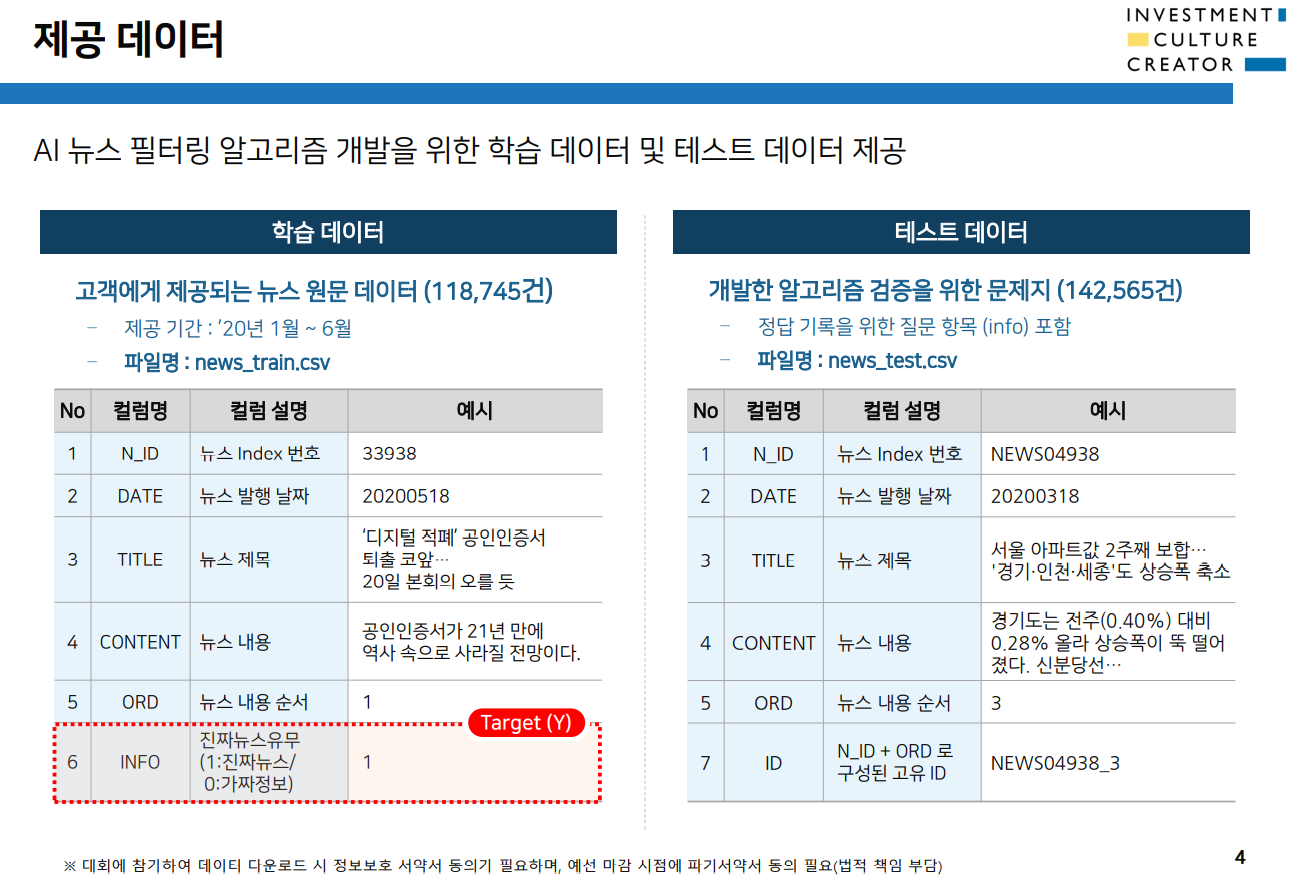

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/drive/My Drive/dacon/schema.png')
display(pil_img)

train 데이터셋에서 진짜 뉴스 개수는 약 4.6만개, 가짜 뉴스 개수는 7.1만개로 4대 4 비율로 분포되어있습니다



In [ ]:
print("진짜 뉴스 개수 : {}".format(len(train.loc[train['info']==0])))
print("가짜 뉴스 개수 : {}".format(len(train.loc[train['info']==1])))
print("진짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==0])) / len(train.index) * 100, 3)))
print("가짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==1])) / len(train.index) * 100, 3)))


진짜 뉴스 개수 : 71813
가짜 뉴스 개수 : 46932
진짜 뉴스 비율 : 60.477%
가짜 뉴스 비율 : 39.523%


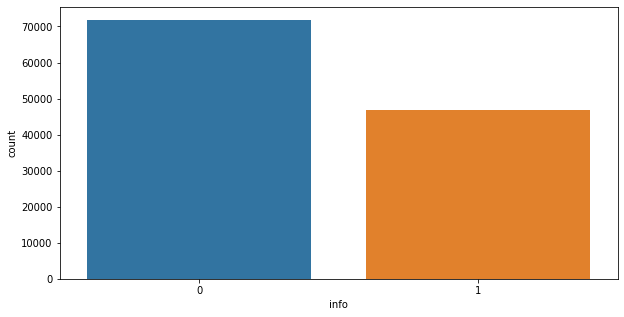

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x="info")


날짜별로 분포도를 보자면 특정 날짜에 진짜 뉴스가 증가하는 것 처럼 보이긴 하지만 점진적으로 증가 또는 변화가 없어 보이기에 일단은 도움이 되지 않는 특징으로 보여집니다.

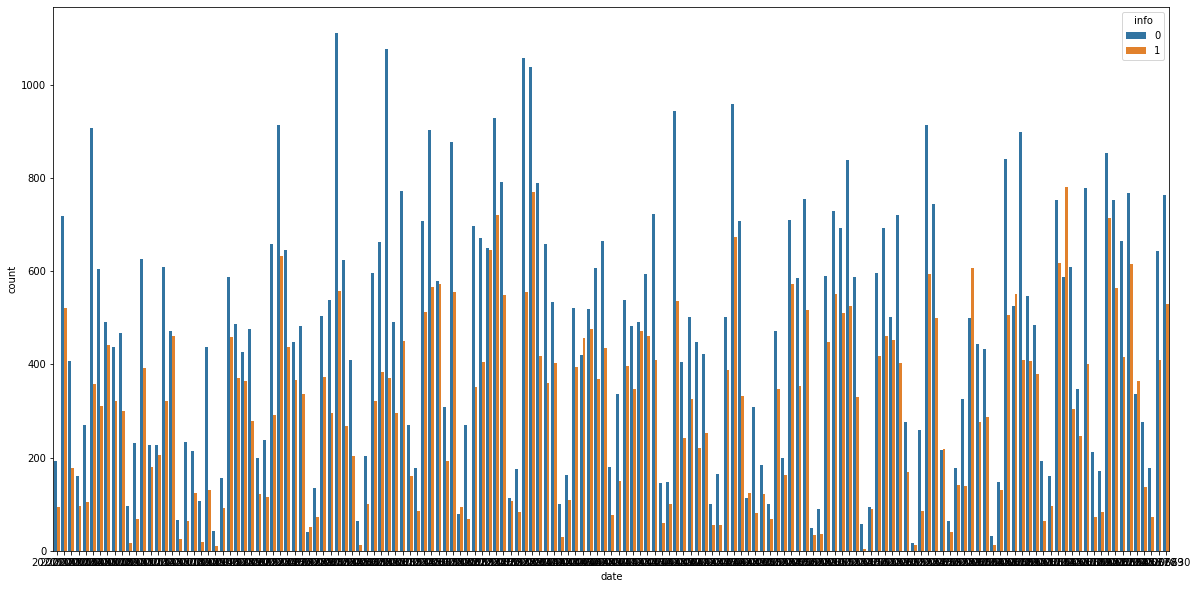

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(data=train, x='date', hue='info')

대부분 뉴스 헤드라인의 길이는 0~250자에 분포되어 있습니다

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


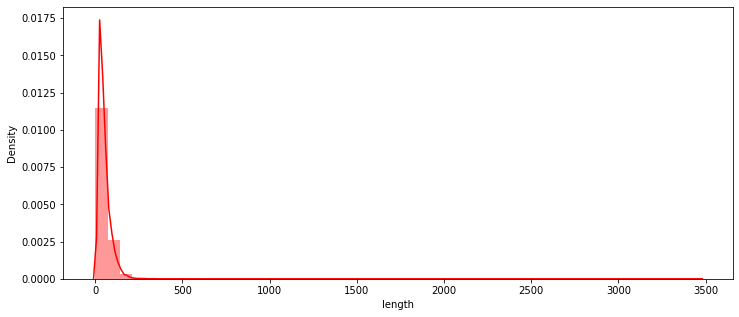

In [ ]:
train['length'] = train['content'].apply(lambda x: len(x))
plt.figure(figsize=(12,5))
sns.distplot(train['length'], color='r')

하지만 진짜, 가짜 뉴스 텍스트의 길이 분포도를 보면 진짜 뉴스는 0-50자 사이에 치우쳐있는 반면, 가짜뉴스는 0-150에 골고루 분포되어있습니다

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


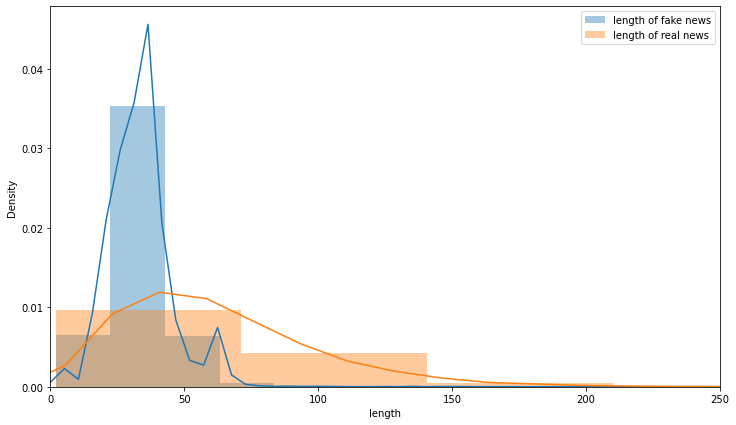

In [ ]:
plt.figure(figsize=(12, 7))
fake = train.loc[train['info']==1]
real = train.loc[train['info']==0]
sns.distplot(fake['length'], label="length of fake news")
sns.distplot(real['length'], label="length of real news")
plt.xlim(0, 250)
plt.legend()


In [ ]:
fake['length'].describe()

count    71813.000000
mean        62.342891
std         43.596060
min          2.000000
25%         34.000000
50%         55.000000
75%         82.000000
max       3469.000000
Name: length, dtype: float64

In [ ]:
real['length'].describe()

count    46932.000000
mean        34.470702
std         20.383651
min          2.000000
25%         27.000000
50%         34.000000
75%         39.000000
max       1022.000000
Name: length, dtype: float64